# TP Smart Sensing: Sparse Coding and Inpainting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Data Generation

### 1) Hyperparameters

In [2]:
n = 100
m = 10
s = 5

### 2) Generating a k-sparse signal

In [3]:
# Generating a full vector with not too small entries
x = np.random.randn(n)
# Generating a support
perm = np.random.permutation(n)
S = perm[0:s]
Sc = perm[s:n]
# Setting non-support elements to zero
x[Sc] = 0
# Plotting x to check it is k sparse (shown later)
#plt.stem(x,use_line_collection=True)
#plt.show

### 3) Generate a sensing matrix

In [4]:
A = np.random.randn(m,n)
A = A/np.linalg.norm(A, axis=0)  #using broadcasting
# computing the linear measurements
y=A@x

### 4) Wrapping it up

In [5]:
def gen_dat(n,m,s):
    x = np.random.randn(n)
    perm = np.random.permutation(n)
    S = perm[0:s]
    Sc = perm[s:n]
    x[Sc] = 0
    A = np.random.randn(m,n)
    A = A/np.linalg.norm(A, axis=0)
    y = A@x
    return x,y,A

def gen_mes(A,k, nonnegative=False):
    n = A.shape[1]
    x = np.random.randn(n)
    if nonnegative:
        x = np.random.rand(n)
    perm = np.random.permutation(n)
    S = perm[0:k]
    Sc = perm[k:n]
    x[Sc] = 0
    y = A.dot(x)
    return x,y

### 5) Displaying x and y for various values of k

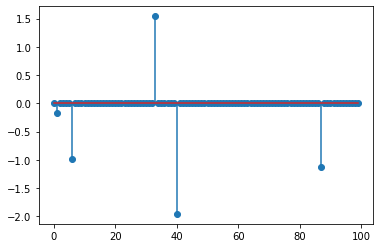

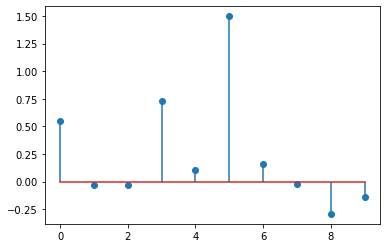

In [6]:
s = 5
x,y = gen_mes(A,s)
plt.stem(x,use_line_collection=True)
plt.show()
plt.stem(y,use_line_collection=True)
plt.show()

## 2. Greedy algorithms: MP and OMP

### 1) Implementing the Matching Pursuit algorithm

In [7]:
# I chose to stop the algorithm when the sparsity level is k
def mpursuit(y,A,s):
    # Dimensions
    m, n = A.shape
    # Initial residual
    res = np.copy(y) 
    # Initial Empty Support
    S = []
    # Initial rec error
    err = [np.linalg.norm(res)**2/m] 
    # Main loop
    while len(S) < s:
        # Compute the cross products
        dotp = abs(A.T@res)
        # Find the best atom wrt dot products
        j = np.argmax(dotp)
        aj = np.transpose(A)[j,:]@res # no absolute value!!
        # If not yet in support, add it
        if j not in S:
            S.append(j)
        # Remove contribution from the residual
        res = res - aj*A[:,j]
        err.append(np.linalg.norm(res)**2/m)

        
    # Now that the support is known, we estimate x by solving an over-determined linear system
    Asupp = A[:,S]
    xS = np.linalg.lstsq(Asupp,y,rcond=None)[0]
    x  = np.zeros(n)
    x[S] = xS
    err.append(np.linalg.norm(y-A@x)**2/m)
    return x, S, err

### 2) Unit test

In [8]:
s = 1
n = 3
m = 2
x,y,A = gen_dat(n,m,s)
x_hat,S,erry = mpursuit(y,A,s)
print(x)
print(x_hat)
err = np.linalg.norm(x_hat-x)**2/n
print(err)

[0.        0.        0.1963557]
[0.        0.        0.1963557]
1.0271626370065257e-33


### Another quick test

9.19448593560477e-11


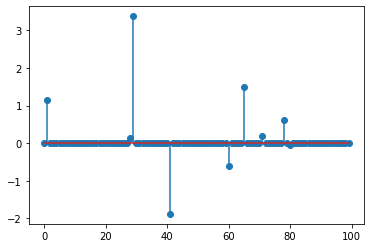

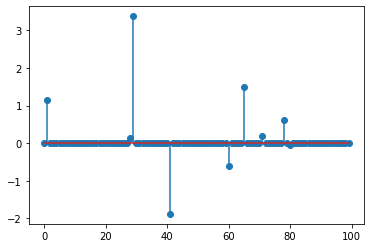

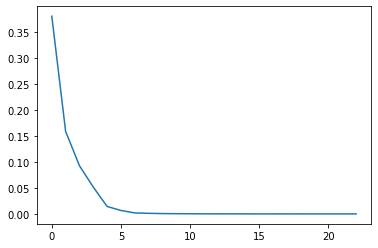

In [9]:
s = 10
n = 100
m = 50
x,y,A = gen_dat(n,m,s)
x_hat,S, erry = mpursuit(y,A,s)
err = np.linalg.norm(x_hat-x)**2/n
print(err)
plt.stem(x,use_line_collection=True)
plt.show()
plt.stem(x_hat,use_line_collection=True)
plt.show()
plt.plot(erry)
plt.show()

### 3-5) Running MP with various sparsity levels

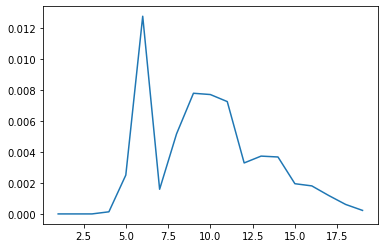

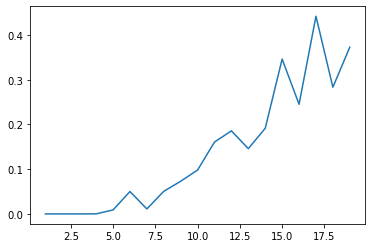

In [10]:
m = 20 # atoms dim
n = 50 # x dim
slist = range(1,m)
A = np.random.randn(m,n)
A = A/np.linalg.norm(A, axis=0)
err = []
erry= []
for s in slist:
    err_temp = []
    erry_temp = []
    for l in range(10):
        x,y = gen_mes(A,s)
        x_hat,S, err_run = mpursuit(y,A,s)
        erry_temp.append(err_run[-1])
        err_temp.append(np.linalg.norm(x_hat-x)**2/n)
    err.append(err_temp)
    erry.append(erry_temp)

# plotting only the mean
err = np.mean(err, axis=1)
erry = np.mean(erry, axis=1)
    
plt.plot(slist,erry)
plt.show()    
plt.plot(slist,err)
plt.show()

### 6) Adding OMP to our military arsenal

In [11]:
# I chose to stop the algorithm after s iterations
def ompursuit(y,A,s):
    # Dimensions
    m, n = A.shape
    # Initial residual
    res = np.copy(y) 
    # Initial Empty Support
    S = []
    # Initial rec error
    err = [np.linalg.norm(res)**2] 
    # Main loop
    while len(S) < s:
        # Compute the cross products
        dotp = abs(A.T@res)
        # Find the best atom wrt dot products
        j = np.argmax(dotp)
        # Add atom to support, it is always a new one
        S.append(j)
        # Find the best x with the given support
        xS = np.linalg.lstsq(A[:,S],y,rcond=None)[0]
        x  = np.zeros(n)
        x[S] = xS
        # Remove contribution from the residual
        res = y - A@x # can be optimized
        err.append(np.linalg.norm(res)**2/m)
    return x, S, err

A unit test

[1.04159472 0.         0.         1.59322962 0.        ]
[ 0.         -1.02229839  0.          1.3958646   0.        ]
0.43379329937217764


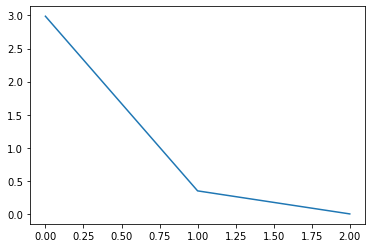

In [12]:
k = 2
n = 5
m = 3
x,y,A = gen_dat(n,m,k)
x_hat,S,erry = ompursuit(y,A,k)
print(x)
print(x_hat)
err = np.linalg.norm(x_hat-x)**2/n
print(err)
plt.plot(erry)
plt.show(erry)

Note: I skipped 13) to drectly do 14) which will give an answer to 13)

### 7-8) Comparing OMP and MP with increasing k

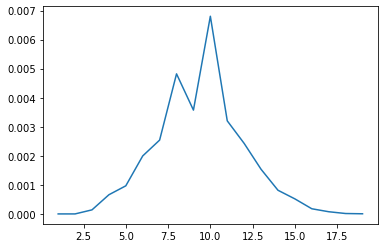

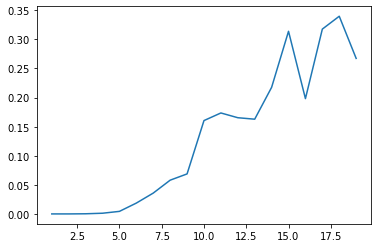

In [13]:
m = 20 # atoms dim
n = 50 # x dim
slist = range(1,m)
A = np.random.randn(m,n)
A = A/np.linalg.norm(A, axis=0)
err = []
erry= []
for s in slist:
    err_temp = []
    erry_temp = []
    for l in range(10):
        x,y = gen_mes(A,s)
        x_hat,S, err_run = ompursuit(y,A,s)
        erry_temp.append(err_run[-1])
        err_temp.append(np.linalg.norm(x_hat-x)**2/n)
    err.append(err_temp)
    erry.append(erry_temp)

# plotting only the mean
err = np.mean(err, axis=1)
erry = np.mean(erry, axis=1)

   
plt.plot(slist,erry)
plt.show()    
plt.plot(slist,err)
plt.show()


## 3. Application: image restoration

### 2) Building the Dictionnary

In [15]:
dims = [40,40] # size of the image atoms
over = 2 # already hard
d = over*40*40 # number of atoms
A = np.zeros([dims[0]*dims[1],d])

for i in range(d):
    # Generate a random couple (x1,x2) which are positions
    # We require that x2 is after x1
    # We limit the maximal size of the rectangle to 20
    # Minimal size is 5
    x1 = np.random.randint(0,dims[1]-6)
    x2 = np.random.randint(x1+5,min(dims[1]-1,x1+20))
    # Generate a random couple (y1,y2)
    # We require that y2 is after y1
    # We limit the maximal size of the rectangle to 20
    y1 = np.random.randint(0,dims[0]-6)
    y2 = np.random.randint(y1+5,min(dims[0]-1,y1+20))
    
    # Generate a matrix with 1 in [x1, x2],[y1,y2]
    atom = np.zeros(dims)
    #atom[x1:x2,y1:y2] = np.float(np.random.randint(5,255)) #not too small
    atom[x1:x2,y1:y2] = np.float(255) #not too small
    # note: I did not use a random sign flip. My images will be nonnegative :)
    
    # Vectorization and placement in D
    A[:,i] = np.reshape(atom,[dims[0]*dims[1],])

A = A/np.linalg.norm(A, axis=0)

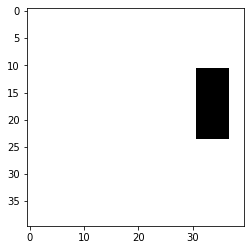

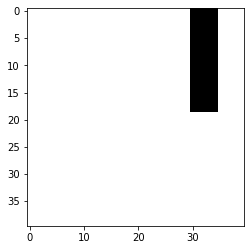

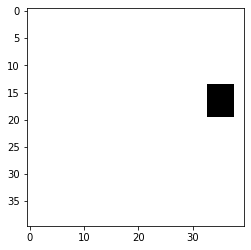

In [17]:
# Some fun with D and the spy function
for i in range(3):
    plt.imshow(np.reshape(A[:,i],dims), cmap='Greys')
    plt.show()

### 3) Let us generate an image !

In [18]:
# Generating x, images y
s = 10
x,y = gen_mes(A,s,nonnegative=True)
# a subroutine to show y
def show_y(y,dims):
    # Reshaping
    image = np.reshape(y,dims)
    # Plotting (no need to clip, this is done internally)
    plt.imshow(image, cmap='Greys')
    plt.show()
    
#show_y(y,dims) # not grayscale but blue-yellow scale

### 4) Missing pixels and noise 5) Display

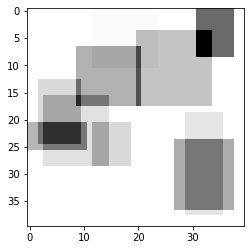

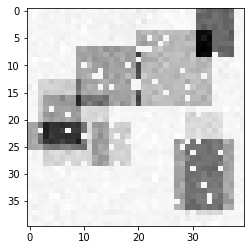

In [19]:
# adding gaussian noise
sigma=0.005
noise = sigma*np.random.randn(np.prod(dims))
ynoise = y+noise

# Generating the set of observed pixels
p = 100 # number of lost pixels
I = np.random.permutation(40**2)[p:] # the remaining pixels
Ibar = np.setdiff1d([i for i in range(40**2)], I) # the lost pixels
#print(Ibar)
# extracting the known pixels and the known dictionary rows
ynoise_I = ynoise[I]
A_I = A[I,:]

# Plotting
ynoise_full = np.copy(ynoise)
ynoise_full[Ibar]=0
show_y(y, dims)
show_y(ynoise_full,dims)

### 6) Image restoration

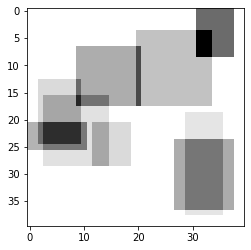

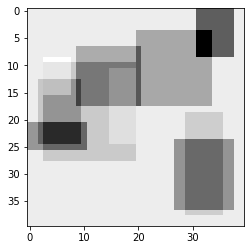

Reconstruction Error for OMP 1.8710232360266514e-06 and MP 7.548826216672636e-05
Peak SNR for OMP 41.34644603505008 and MP 25.288443570029248
Running time for OMP 0.12311530113220215 and MP 0.03415322303771973


In [21]:
# Using omp to reconstruct from the noisy image
t=time.time()
x_omp,S_omp,_ = ompursuit(ynoise_I,A_I,s)
time_omp = time.time()-t
t=time.time()
x_mp,S_mp,_ = mpursuit(ynoise_I,A_I,s)
time_mp = time.time() - t
y_omp = A@x_omp
y_mp = A@x_mp

show_y(y_omp,dims)
show_y(y_mp,dims)

# Reconstruction error?
mse_omp = np.linalg.norm(y-y_omp)**2/1600
mse_mp = np.linalg.norm(y-y_mp)**2/1600
print('Reconstruction Error for OMP {} and MP {}'.format(mse_omp,mse_mp))
# PSNR?
dyn = np.max(y)-np.min(y)
psnr_omp = 10*np.log10(dyn**2/mse_omp)
psnr_mp = 10*np.log10(dyn**2/mse_mp)
print('Peak SNR for OMP {} and MP {}'.format(psnr_omp,psnr_mp))
# Computation time
print('Running time for OMP {} and MP {}'.format(time_omp,time_mp))

### 7) Checking support estimation

In [22]:
# Computing the legnth of the difference between the true support and the estimated support
# re-estimate support
S = np.argsort(x)
S = np.sort(S[-s:]) # sorting for convenient visualisation
S_omp = np.sort(S_omp)
S_mp = np.sort(S_mp)
# Setdiff with the estimated support
setdiff_omp = np.setdiff1d(S,S_omp)
setdiff_mp = np.setdiff1d(S,S_mp)
print('The missing atoms in OMP and MP estimates are',setdiff_omp,setdiff_mp)

The missing atoms in OMP and MP estimates are [2439 2695] [ 112 2251 2439 2695]
